In [ ]:
#!pip install git+https://github.com/python-graphblas/python-graphblas

  Cloning https://github.com/python-graphblas/python-graphblas to /tmp/pip-req-build-rpw95nrr
  Running command git clone --filter=blob:none --quiet https://github.com/python-graphblas/python-graphblas /tmp/pip-req-build-rpw95nrr
  Resolved https://github.com/python-graphblas/python-graphblas to commit 27b23e414a9a73daa9c3dda9698e227562d9a18c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 11.4 MB/s eta 0:00:00
  Created wheel for python-graphblas: filename=python_graphblas-2024.2.0+2.g27b23e41-py3-none-any.whl size=351142 sha256=9f9ffbded40a8b725601c012389020165e8c5f0490a3b9c4d35106dff21ad3cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-x_0o93a1/wheels/1d/ff/e1/7abbc85fde1376805d105bcb709a635cac5d6fcf1cc6f7d3ad
Successfully built python-graphblas


In [ ]:
import graphblas as gb
gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np

**Наивный алгоритм**

In [ ]:
def NaiveA3(A):
  #возводим в куб матрицу смежности
  #функция ожидает на вход формат coo
  A2=A.mxm(A)
  A3=A2.mxm(A)
  #получаю вектор из элементов главной диагонали
  tri2=A3.diag()
  #подсчитываю сумму элементов диагонали (результат делю на 6)
  cnt_triangle=(tri2.reduce(gb.agg.sum).value or 0)
  return int(cnt_triangle/6)

**Наивный алгоритм с маской**

In [ ]:
def NaiveA2(A):
  #возводим в квадрат матрицу смежности
  #функция ожидает на вход формат coo
  A2=A.mxm(A)
  #"просеиваю" квадрат матрицы смежности через маску
  triA=A2.dup(mask=A.dup(dtype=dtypes.BOOL))
  #получаем результат путем вычисления суммы построчных сумм элементов матрицы
  cnt_triangle=(triA.reduce_scalar(gb.monoid.plus).value or 0)
  return int(cnt_triangle/6)

**Cohen's алгоритм**

In [ ]:
def Cohens(A):
  #получаю верхне- и нижнетреугольные матрицы из матрицы А
  #функция ожидает на вход формат coo
  L=gb.select.tril(A)
  U=gb.select.triu(A)
  #
  B=L.mxm(U)
  #"просеиваю" полученную матрицу
  C=B.dup(mask=A.dup(dtype=dtypes.BOOL))
  #подсчитываю количество треугольников, исключая повторяющиеся
  t=(C.reduce_scalar(gb.monoid.plus).value or 0)/2
  return int(t)

**Sandia алгоритм**

In [ ]:
def Sandia(A):
  #получаю верхне-треугольную матрицы из матрицы А
  #функция ожидает на вход формат coo
  L=gb.select.tril(A)
  #нахожу квадрат верхне-треугольной матрицы
  #"просеиваю" по маске этой же матрицы
  C=L.mxm(L).dup(mask=L.dup(dtype=dtypes.BOOL))
  #подсчитываю сумму элементов матрицы
  t=(C.reduce_scalar(gb.monoid.plus).value or 0)
  return int(t)

**Функция подсчета количество треугольников для вершины**

Так как элемент An(i)(j) для матрицы смежности отражает количество переходов от вершины i к вершине j. В таком случае при n=3 мы получаем путь длиной 3, тогда для элементов диагонали мы получим треугольник (путь длиной 3 с началом и концом в вершине). Поскольку пути i-x-y-i и i-y-x-i будут учтены дважды, делим значение элемента на диагонали на 2. Далее вектор из этих элементов и будет ответом.

In [ ]:
def cntTriangles(A):
  #получаю количество строк и столбцов (вершин графа)
  cols, rows=A.shape
  #возводим в куб матрицу смежности
  #функция ожидает на вход формат coo
  A2=A.mxm(A)
  A3=A2.mxm(A)
  #получаю вектор из элементов главной диагонали
  #делю на 2, чтобы не дублировать треугольники
  tri2=A3.diag()/2
  #задаю массив с количеством треугольников для каждой вершины графа (по умолчанию 0)
  #использую, чтобы учесть None как 0
  cnt_tri=np.array([0]*rows)
  #прохожусь по векторам индексов и значений, чтобы изменить не None значения в массиве
  for i in range(len(tri2.to_coo()[0])):
    cnt_tri[tri2.to_coo()[0][i]]=int(tri2.to_coo()[1][i])
  return cnt_tri

**Тестирование реализаций**

Задам 5 тренировочных матриц смежности, выведу для них визуальное представление графа (матрицы симметричные, чтобы граф был неориентированным) и далее сравню результат функций с правильным.

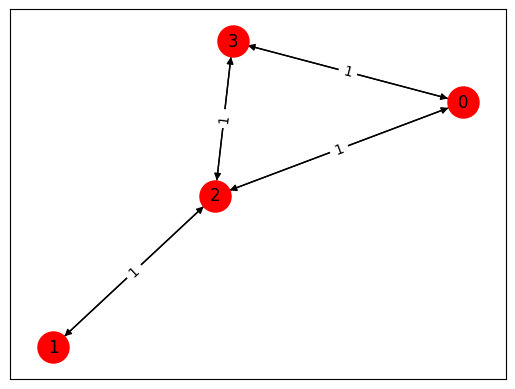

In [ ]:
#для начала задам простой граф с 4 вершинами и 1 треугольником, в котором участвуют вершины 0, 2 и 3.
M1=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3],
    [2,0,3,2,1,3,0,2],
    [1,1,1,1,1,1,1,1],
    nrows=4,
    ncols=4
)
gb.viz.draw(M1)
#проверяю, что все функции возвращают корректный результат
assert NaiveA3(M1) == 1
assert NaiveA2(M1) == 1
assert Cohens(M1) == 1
assert Sandia(M1) == 1
assert (cntTriangles(M1) == np.array([1, 0, 1, 1])).all()

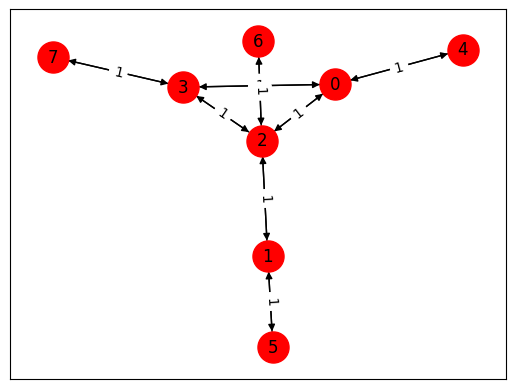

In [ ]:
#увеличу количество вершин до 8, при это оставлю 1 треугольник, в котором участвуют вершины 0, 2 и 3.
M2=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3,4,5,6,7,3,2,1,0],
    [2,0,3,2,1,3,0,2,0,1,2,3,7,6,5,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    nrows=8,
    ncols=8
)
gb.viz.draw(M2)
#проверяю, что все функции возвращают корректный результат
assert NaiveA3(M2) == 1
assert NaiveA2(M2) == 1
assert Cohens(M2) == 1
assert Sandia(M2) == 1
assert (cntTriangles(M2) == np.array([1, 0, 1, 1, 0, 0, 0, 0])).all()

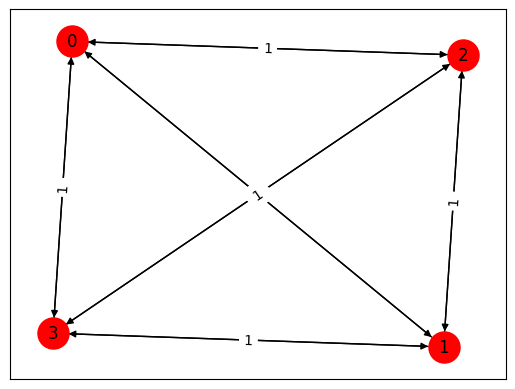

In [ ]:
#верну 4 вершины, но теперь каждая из вершин будет участвовать в 3х треугольниках (всего треугольников будет 4)
M3=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3,1,0,3,1],
    [2,0,3,2,1,3,0,2,0,1,1,3],
    [1,1,1,1,1,1,1,1,1,1,1,1],
    nrows=4,
    ncols=4
)
gb.viz.draw(M3)
#проверяю, что все функции возвращают корректный результат
assert NaiveA3(M3) == 4
assert NaiveA2(M3) == 4
assert Cohens(M3) == 4
assert Sandia(M3) == 4
assert (cntTriangles(M3) == np.array([3, 3, 3, 3])).all()

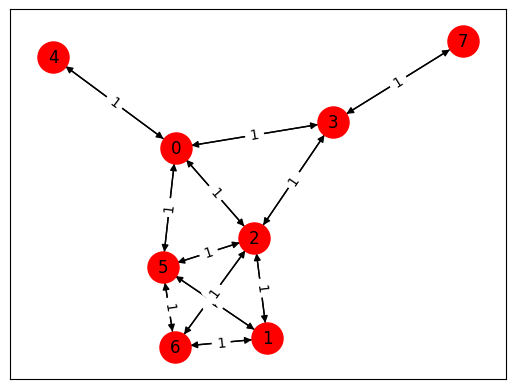

In [ ]:
#увеличу количество вершин до 8, и пусть каждая участвует в нескольких треугольниках
#вершина 0 - в двух, вершины 1 и 6 - в трех, вершина 2 - в пяти
#вершина 3 - в одном, вершины 4 и 7 - ни в одном, вершина 5 - в четырех
#всего треугольников при этом будет 6
M4=gb.Matrix.from_coo(
    [0,2,0,1,2,2,3,3,4,5,6,7,3,2,1,0,6,5,0,5,6,1,5,2],
    [2,0,3,2,1,3,0,2,0,1,2,3,7,6,5,4,5,6,5,0,1,6,2,5],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    nrows=8,
    ncols=8
)
gb.viz.draw(M4)
#проверяю, что все функции возвращают корректный результат
assert NaiveA3(M4) == 6
assert NaiveA2(M4) == 6
assert Cohens(M4) == 6
assert Sandia(M4) == 6
assert (cntTriangles(M4) == np.array([2, 3, 5, 1, 0, 4, 3, 0])).all()

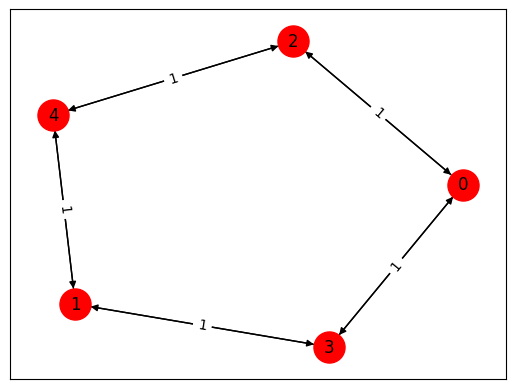

In [ ]:
#задам граф вообще без треугольников с 5 вершинами
M5=gb.Matrix.from_coo(
    [3,1,0,2,0,3,4,1,4,2],
    [1,3,2,0,3,0,1,4,2,4],
    [1,1,1,1,1,1,1,1,1,1],
    nrows=5,
    ncols=5
)
gb.viz.draw(M5)
#проверяю, что все функции возвращают корректный результат
assert NaiveA3(M5) == 0
assert NaiveA2(M5) == 0
assert Cohens(M5) == 0
assert Sandia(M5) == 0
assert (cntTriangles(M5) == np.array([0, 0, 0, 0, 0])).all()

**Тестирование на "реальных" графах**

In [ ]:
#функция тестирования
#получаю время выполнения через timeit
def test_time(A):
  print('NaiveA3:')
  %timeit NaiveA3(A)
  print('NaiveA2:')
  %timeit NaiveA2(A)
  print('Cohens:')
  %timeit Cohens(A)
  print('Sandia:')
  %timeit Sandia(A)

In [ ]:
realGraph1=mmread('can_838.mtx')
realGraph2=mmread('lshp1561.mtx')
realGraph3=mmread('cegb2802.mtx')
realGraph4=mmread('fxm3_6.mtx')
realGraph5=mmread('wing_nodal.mtx')
realGraph6=mmread('pds10.mtx')
realGraph7=mmread('pf2177.mtx')
realGraph8=mmread('pkustk02.mtx')
realGraph9=mmread('tandem_vtx.mtx')
realGraph10=mmread('tsyl201.mtx')

In [ ]:
graphAr=[realGraph1, realGraph2, realGraph3, realGraph4, realGraph5, realGraph6, realGraph7, realGraph8, realGraph9, realGraph10]
for i in graphAr:
  print(f'Количество вершин: {i.shape[0]}, количество ребер: {len(i.to_coo()[0])}')
  print(test_time(i))

Количество вершин: 838, количество ребер: 10010
NaiveA3:
5.98 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
NaiveA2:
696 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohens:
703 µs ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
371 µs ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 1561, количество ребер: 10681
NaiveA3:
2.81 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
NaiveA2:
721 µs ± 164 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohens:
534 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
391 µs ± 7.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 2802, количество ребер: 277362
NaiveA3:
207 ms ± 7.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
NaiveA2:
74.6 ms ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Cohens:
The slowest run took 4.94 times longe

По результатам теста очевидно, что:
1. Наивный алгоритм значительно медленнее всех остальных. При этом с увеличением количества вершин/средней плотности разница только растет.
2. Наивный алгоритм с маской работает намного быстрее обычного наивного за счет замены тяжеловесного умножения матриц.
3. Что касается алгоритмов Cohens и Sandia, они работают на порядок быстрее, при этом наиболее эффективным показал себя алгоритм Sandia.

**Тестирование случайных графов**

Функция генерации принимает на вход количество вершин и ребер. Далее случайным образом отбираются случайные пары вершин (из элементов выше диагонали матрицы смежности) по количеству указанных ребер. После этого индексы выбранных вершин (и симметричные им, т.к. граф неориентированный) добавляются в списки. В ответ возвращается матрица, которая генерируется из формата соо по спискам индексов и значений (для всех ребер вес 1).

In [ ]:
def gen_random_graphs(rows, reber):
  import random
  #задаю множества, так как номера элементов уникальны
  set1=set()
  #создаю верхний треугольник матрицы смежности в формате множества
  for i in range(rows**2):
    if i//rows<i%rows:
      set1.add(i)
  #выбираю случайные индексы вершин для создания ребер согласно входному параметру
  x=random.sample(set1, reber)
  #использую списки для формирования ответа в формате соо
  indices_from=[]
  indices_to=[]
  #прохожусь по выбранным ребрам и записываю вершины в списки
  #добавляю в списке 2 ребра между указанными вершинами (т.к. граф неориентированный)
  for i in x:
    indices_from.append(i//rows)
    indices_to.append(i%rows)
    indices_from.append(i%rows)
    indices_to.append(i//rows)

  return gb.Matrix.from_coo(
      indices_from,
      indices_to,
      [1]*len(indices_from),
      nrows=rows,
      ncols=rows
    )

In [ ]:
#как ведет себя время для очень разреженых графов с увеличением числа вершин
for i in range(1000,10000,1000):
  print(f'Количество вершин: {i}, количество ребер: 1')
  randGraph=gen_random_graphs(i, 1)
  print(test_time(randGraph))

Количество вершин: 1000, количество ребер: 1


<ipython-input-1-145c16b95be0>:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x=random.sample(set1, reber)


NaiveA3:
216 µs ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
NaiveA2:
176 µs ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Cohens:
330 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
249 µs ± 8.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 2000, количество ребер: 1
NaiveA3:
276 µs ± 52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
NaiveA2:
245 µs ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohens:
337 µs ± 32.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
243 µs ± 15.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 3000, количество ребер: 1
NaiveA3:
196 µs ± 5.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
NaiveA2:
179 µs ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Cohens:
408 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
262 µs 

1. Наивный алгоритм почти всегда быстрее своих оптимизированных "коллег" (так как алгоритмы Cohen и Sandia рассчитаны, в первую очередь, на более плотные графы с большим количеством вершин).
2. Наиболее эффективным по времени оказался наивный алгоритм с маской, оптимизирующий наивный алгоритм путем замены дорогой по времени операции умножения матриц на поэлементное умножение (или "просеивание" через маску).
3. Однако, результаты теста нельзя назвать значимыми для практического применения, поскольку очень редко на практике приходится работать с относительно малыми и настолько разреженными графами.

In [ ]:
#как ведет себя время для графов с повышением плотности
for i in range(10000,100000,10000):
  print(f'----------------------------------------------')
  print(f'Количество вершин: 500, количество ребер: {i}')
  randGraph=gen_random_graphs(500, i)
  print(test_time(randGraph))

----------------------------------------------
Количество вершин: 500, количество ребер: 10000
NaiveA3:


<ipython-input-1-145c16b95be0>:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  x=random.sample(set1, reber)


24.1 ms ± 893 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
NaiveA2:
The slowest run took 6.43 times longer than the fastest. This could mean that an intermediate result is being cached.
8.21 ms ± 7.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohens:
2.27 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Sandia:
1.58 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
----------------------------------------------
Количество вершин: 500, количество ребер: 20000
NaiveA3:
41.4 ms ± 8.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
NaiveA2:
22.2 ms ± 8.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohens:
6.7 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Sandia:
3.68 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
----------------------------------------------
Количество вершин: 500, количество ребер: 30000
NaiveA3:
70.7 ms ± 21.9 ms per loop (mean ± std. dev. 

1. С увеличением плотности графа с большим числом вершин наивный алгоритм стал значительно проигрывать более оптимальным подходам.
2. Наивный алгоритм с маской по-прежнему немного более эффективен за счет отказа от дорогостоящего перемножения матриц (однако, на некоторых примерах работает даже дольше обычного наивного).
3. Наиболее эффективным алгоритмом по результатам теста оказался Sandia, поскольку использует только верхний треугольник исходной матрицы смежности графа. Также алгоритм наиболее эффективен и по занимаемой памяти, т.к. хранит только верхнетреугольную матрицу (в отличие от Cohen, в котором хранятся 2: верхнетреугольная и нижнетреугольная).
4. Можно сказать о том, что результаты этого теста практически применимы. Алгоритмы Sandia и Cohen's предпочтительно использовать при решении практических задач.


**Основные выводы**

 1. Анализ графовых данных имеет практическое применение в следующих задачах:
- кластеризация клиентов и предсказание связей (например, при рекомендациях друзей в соц. сетях по общим группам или контактам);
- анализ сходства (например, для подбора аудитории для рекламы чего-либо, формирования фокус-групп);
- всевозможные банковские скоринги (через связи между руководителями разных фирм, совместными проектами и влиянием друг на друга);
- выявление мошенничества (через анализ связей клиентов с потенциальными мошенниками и сравнение данных с реальными мошшеническими действиями);
- построение и оптимизация маршрутов (актуально в приложениях и платформах карт).
 2. Наивный алгоритм можно использовать при очень плотных или очень разреженных матрицах, в остальных случаях (в т.ч. при реальных задачах, что показал тест на графах с сайта) более оптимальным (по времени и памяти) является, в первую очередь, алгоритм Sandia. Также неплохие результаты показывает Cohen's алгоритм.
